<a href="https://colab.research.google.com/github/MohammadRaziei/Deep-Learning-Course/blob/master/HW05/HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW05

Please check last updates and get the latest version from following link. it is more completed but it may have some updates after release it.

[<img src="https://img.icons8.com/clouds/50/000000/github.png"/>](https://github.com/MohammadRaziei/Deep-Learning-Course/blob/master/)  
github link : https://github.com/MohammadRaziei/Deep-Learning-Course/blob/master/HW05

## Preparing

Installing needed modules

In [1]:
!pip install music21
!pip install bs4
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 18.3MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=338da41b67764c39e433bb806baf518b48947ed1731002ab5a14422893b8bfaa
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [2]:
import os, shutil
def create_empty_folder(folder_name, recreate=True):
  try:
    if recreate:
      try: shutil.rmtree(folder_name)
      except: pass
    os.mkdir(folder_name)
    print('"%s" is created.'%folder_name)
  except Exception as e: # work on python 3.x
    print('Some error! : '+ str(e))

def create_empty_folders(folders_list):
  for folder in folders_list:
    create_empty_folder(folder)

## Part O

In [3]:
from urllib.request import urlopen, urlretrieve
from bs4 import BeautifulSoup
import time
from tqdm.auto import trange


selected_instrument = 'Guitar'

# Define URL components
url_base = 'https://www.mutopiaproject.org/cgibin/make-table.cgi?startat={}&searchingfor=&Composer=&Instrument={}&Style=&collection=&id=&solo=&recent=&timelength=&timeunit=&lilyversion=&preview='

# Define save directory.
save_dir = 'guitar'
create_empty_folder(save_dir)

# Set initial values
songNumber = 0
linkCount = 10

lim = 10 
cnt = 0

# Locate and download each MIDI file
for cnt in trange(lim):
    cnt += 1
    url = url_base.format(songNumber, selected_instrument)
    html = urlopen(url)
    soup = BeautifulSoup(html.read())
    links = soup.find_all('a')
    linkCount = 0
    for link in links:
        href = link['href']
        if href.find('.mid') >= 0:
            linkCount = linkCount + 1
            urlretrieve(href, os.path.join(save_dir, "%d_%d.mid"%(cnt, linkCount)))
    if linkCount is 0: break
    songNumber += 10
    time.sleep(.1)

"guitar" is created.


In [4]:
from music21 import converter, instrument, note, chord, stream, midi
import pandas as pd
import numpy as np


# Melody-RNN Format is a sequence of 8-bit integers indicating the following:
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# Each element in the sequence lasts for one sixteenth note.
# This can encode monophonic music only.

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output


def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a dataframe.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]


def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row.code == MELODY_NO_EVENT:
            new_note = note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row.code == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream


In [5]:
import glob, os
import numpy as np
from tqdm.auto import tqdm
import time

midi_files = glob.glob(os.path.join(save_dir, '*.mid'))
training_arrays = []
for f in tqdm(midi_files):
    try:    s = converter.parse(f)
    except: continue
    arr = streamToNoteArray(s.parts[0]) # just extract first voice
    training_arrays.append(arr)

training_dataset = np.array(training_arrays)
np.savez('melody_training_dataset.npz', data=training_dataset)  # save data to .npz file

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [6]:
train_set = np.load('./melody_training_dataset.npz', allow_pickle=True)
train_set = train_set['data']

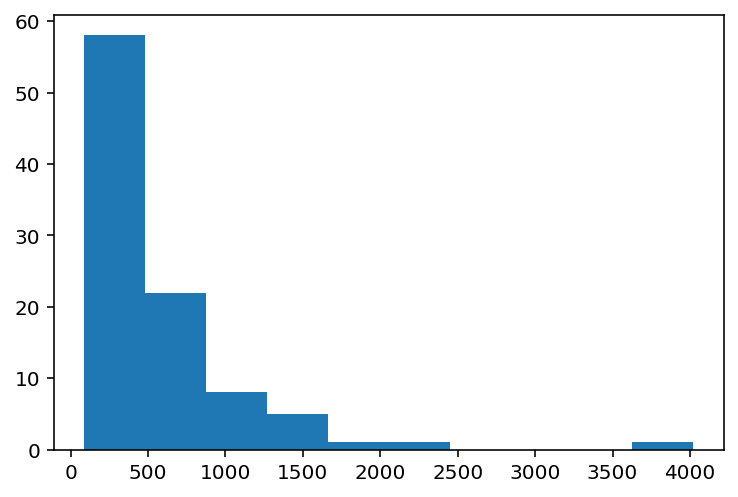

In [7]:
import matplotlib.pyplot as plt

music_size = []
for music in train_set:
    music_size.append(len(music))
music_size = np.array(music_size)
plt.hist(music_size)
plt.show()

## Part I

In [8]:
from music21 import converter, instrument, note, chord, stream, midi
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm.auto import tqdm, trange

def get_notes(save_dir=save_dir):
    """ Get all the notes and chords from the midi files """
    notes = []
    midi_files = glob.glob(os.path.join(save_dir, '*.mid'))

    for file in tqdm(midi_files):
        midi = converter.parse(file)
        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes


def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in trange(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab)/2) / (float(n_vocab)/2)
    network_output = to_categorical(network_output)

    return (network_input, network_output)

In [27]:
def generate_notes(model, network_input, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)
    
    # Get pitch names and store in a dictionary
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        
        pattern = numpy.append(pattern,index)
        #pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output
  
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))


In [80]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.layers import LSTM as CuDNNLSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss=BinaryCrossentropy(), optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential(name='discriminator')
        model.add(Input(shape=self.seq_shape, name='discriminator_Input'))
        model.add(CuDNNLSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(CuDNNLSTM(512)))
        model.add(Dense(512, name='discriminator_Dense1'))
        model.add(LeakyReLU(alpha=0.2, name='discriminator_LeakyReLU1'))
        model.add(Dense(256, name='discriminator_Dense2'))
        model.add(LeakyReLU(alpha=0.2, name='discriminator_LeakyReLU2'))
        model.add(Dense(1, activation='sigmoid', name='discriminator_Output'))
        # model.summary()
        # seq = Input(shape=self.seq_shape)
        # validity = model(seq)
        # return Model(seq, validity)
        return model
      
    def build_generator(self):

        model = Sequential(name='generator')
        model.add(Input(shape=(self.latent_dim,), name='generator_Input'))
        model.add(Dense(256, input_dim=self.latent_dim, name='generator_Dense1'))
        model.add(LeakyReLU(alpha=0.2, name='generator_LeakyReLU1'))
        model.add(BatchNormalization(momentum=0.8, name='generator_BatchNormalization1'))
        model.add(Dense(512, name='generator_Dense2'))
        model.add(LeakyReLU(alpha=0.2, name='generator_LeakyReLU2'))
        model.add(BatchNormalization(momentum=0.8, name='generator_BatchNormalization2'))
        model.add(Dense(1024, name='generator_Dense3'))
        model.add(LeakyReLU(alpha=0.2, name='generator_LeakyReLU3'))
        model.add(BatchNormalization(momentum=0.8, name='generator_BatchNormalization3'))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh', name='generator_Dense4'))
        model.add(Reshape(self.seq_shape, name='generator_Output'))
        # model.summary()
        # noise = Input(shape=(self.latent_dim,))
        # seq = model(noise)
        # return Model(noise, seq)
        return model

    def load_data(self):
        # Load and convert the data
        print('Data is loading...')
        self.notes = get_notes()
        n_vocab = len(set(self.notes))
        self.dataset = prepare_sequences(self.notes, n_vocab)

    def train(self, epochs, batch_size=128, sample_interval=50):
        notes = self.notes
        X_train, y_train = self.dataset

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch+1, d_loss[0], 100*d_loss[1], g_loss))
              self.disc_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        
        # self.generate(notes)
        # self.plot_loss()
        
    def generate(self):
        # Get pitch names and store in a dictionary
        notes = self.notes
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise).squeeze()
        map_to_int_notes = lambda n: int(len(int_to_note)*(n+1)/2)
        pred_notes = [map_to_int_notes(x) for x in predictions]

        pred_notes = [int_to_note[x] for x in pred_notes]
        
        create_midi(pred_notes, 'gan_final')
        
    def plot_loss(self, show=True):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.show() if show else plt.close()


In [91]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
gan = GAN(rows=100)
gan.load_data()    

## Part I

In [ ]:
plot_model(gan.generator, show_shapes=True, to_file='generator.png')
display(Image('generator.png',width=500))
print('\n\n')
gan.generator.summary()

## Part II

In [ ]:
plot_model(gan.discriminator, show_shapes=True, to_file='discriminator.png')
display(Image('discriminator.png',width=500))
print('\n\n')
gan.discriminator.summary()

## Part III

In [95]:
gan.train(epochs=2000, batch_size=32, sample_interval=1)

1 [D loss: 0.304332, acc.: 93.75%] [G loss: 1.194966]
2 [D loss: 0.266465, acc.: 84.38%] [G loss: 3.223686]
3 [D loss: 0.348114, acc.: 89.06%] [G loss: 2.382097]
4 [D loss: 0.232798, acc.: 90.62%] [G loss: 2.517748]
5 [D loss: 0.332336, acc.: 89.06%] [G loss: 2.464393]
6 [D loss: 0.316981, acc.: 85.94%] [G loss: 2.248592]
7 [D loss: 0.249473, acc.: 90.62%] [G loss: 2.647002]
8 [D loss: 0.224607, acc.: 87.50%] [G loss: 2.686421]
9 [D loss: 0.296104, acc.: 89.06%] [G loss: 2.735219]
10 [D loss: 0.326570, acc.: 87.50%] [G loss: 2.631201]
11 [D loss: 0.430828, acc.: 78.12%] [G loss: 2.262186]
12 [D loss: 0.209593, acc.: 92.19%] [G loss: 2.245986]
13 [D loss: 0.221166, acc.: 87.50%] [G loss: 2.693698]
14 [D loss: 0.393704, acc.: 87.50%] [G loss: 2.729472]
15 [D loss: 0.167818, acc.: 93.75%] [G loss: 3.172782]
16 [D loss: 0.357953, acc.: 81.25%] [G loss: 3.128950]
17 [D loss: 0.448408, acc.: 82.81%] [G loss: 2.367487]
18 [D loss: 0.252953, acc.: 90.62%] [G loss: 2.843935]
19 [D loss: 0.25968

## Part IV

In [96]:
gan.generate()
# it saved as 'gan_final.midi'

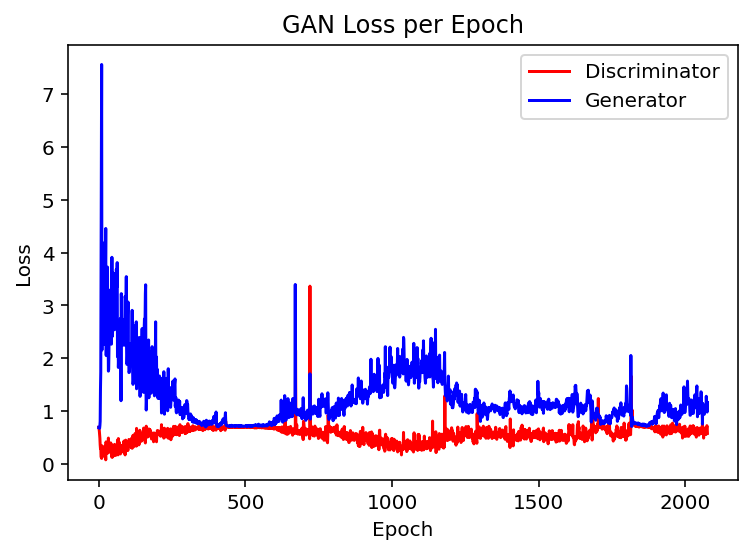

In [97]:
gan.plot_loss()